In [1]:
# https://zenn.dev/google_cloud_jp/articles/97002c462e9025
# 【マルチモーダル・マルチエージェント開発の総仕上げ】Agent Development Kit でイメージデザイン・アシスタントを作成する

%pip install --upgrade --user \
    google-adk==1.2.1 \
    google-cloud-aiplatform==1.96.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
import IPython
app = IPython.Application.instance()
_ = app.kernel.do_shutdown(True)

In [1]:
import base64, copy, json, os, re, time, uuid
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image

import vertexai
from google.cloud import storage
from google import genai
from google.genai import types
from google.genai.types import (
    HttpOptions, GenerateContentConfig, GenerateImagesConfig,
    Part, Content
)
from google.adk.agents.llm_agent import LlmAgent
from google.adk.artifacts import InMemoryArtifactService
from google.adk.memory.in_memory_memory_service import InMemoryMemoryService
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.adk.tools import ToolContext
from google.adk.agents.callback_context import CallbackContext
from google.adk.models import LlmRequest, LlmResponse

[PROJECT_ID] = !gcloud config list --format 'value(core.project)'
LOCATION = 'us-central1'

vertexai.init(
    project=PROJECT_ID,
    location=LOCATION,
    staging_bucket=f'gs://{PROJECT_ID}'
)

os.environ['GOOGLE_CLOUD_PROJECT'] = PROJECT_ID
os.environ['GOOGLE_CLOUD_LOCATION'] = LOCATION
os.environ['GOOGLE_GENAI_USE_VERTEXAI'] = 'True'

BUCKET_NAME = f'{PROJECT_ID}-adk-design'

In [2]:
!gsutil mb -b on -l {LOCATION} gs://{BUCKET_NAME}

Creating gs://zenn-test-457807-adk-design/...
ServiceException: 409 A Cloud Storage bucket named 'zenn-test-457807-adk-design' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [3]:
def generate_response(system_instruction, contents,
                      response_schema, model='gemini-2.0-flash-001'):
    client = genai.Client(vertexai=True,
                          project=PROJECT_ID, location=LOCATION,
                          http_options=HttpOptions(api_version='v1'))
    response = client.models.generate_content(
        model=model,
        contents=contents,
        config=GenerateContentConfig(
            system_instruction=system_instruction,
            temperature=0.4,
            response_mime_type='application/json',
            response_schema=response_schema,
        )
    )
    return '\n'.join(
        [p.text for p in response.candidates[0].content.parts if p.text]
    )

In [4]:
def generate_image(image_prompt, model='imagen-3.0-generate-002'):
    client = genai.Client(vertexai=True,
                          project=PROJECT_ID, location=LOCATION,
                          http_options=HttpOptions(api_version='v1'))
    response = client.models.generate_images(
        model=model,
        prompt=image_prompt,
        config=GenerateImagesConfig(
            number_of_images=1,
        )
    )
    pil_image = response.generated_images[0].image._pil_image
    output = BytesIO()
    pil_image.save(output, format='PNG')
    image_bytes = output.getvalue()
    return image_bytes

In [6]:
def upload_image(image_bytes, blob_name, bucket_name=BUCKET_NAME):
    client = storage.Client()
    blob = client.bucket(bucket_name).blob(blob_name)
    blob.upload_from_string(image_bytes, content_type='image/png')

In [7]:
def display_image_bytes(image_bytes, title):
    img = Image.open(BytesIO(image_bytes))
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(img)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

def display_image(blob_name, title, bucket_name=BUCKET_NAME):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    image_bytes = bucket.blob(blob_name).download_as_bytes()
    display_image_bytes(image_bytes, title)

In [8]:
async def generate_image_tool(
    description: str, purpose: str,
    tool_context: ToolContext
) -> dict:
    """
    Generate an image based on description and its purpose.

    Args:
        description: short description of an image that the user wants to create.
        purpose: the purpose of an image that the user wants to use the image for.
       
    Returns:
        dict: A dictionary with the following keys:
            image_id: unique id of the image
            error: error message in case of exception
    """
    try:
        system_instruction = '''
Generate a text string that will be used as a prompt to generate an image with Imagen.
Based on the following user input, add detailed information as much as possibe.

[description]: Description of an image.
[purpose]: The purpose of an image that the user wants to use the image for.
'''
        contents = f'''
[description]
{description}

[purpose]
{purpose}
'''
        response_schema = {
            "type": "object",
            "properties": {
                "prompt": {"type": "string"},
            },
            "required": ["prompt"],
        }

        response = json.loads(
            generate_response(system_instruction, contents, response_schema)
        )
        image_bytes = generate_image(response['prompt'])
        image_artifact = Part(
            inline_data=types.Blob(
                mime_type='image/png',
                data=image_bytes
            )
        )
        # Save image as artifact
        image_id = uuid.uuid4().hex
        await tool_context.save_artifact(filename=image_id, artifact=image_artifact)
        return {'image_id': image_id}

    except Exception as e:
        return {'error': f'Error creating image: {e}'}

In [9]:
async def save_image_tool(
    image_id: str, filename: str,
    tool_context: ToolContext
) -> dict:
    """
    Tool to save an image.

    Args:
        image_id: unique id of the image
        filename: destination filename

    Returns:
        dict: A dictionary containing the plan with the following keys:
            result: a text message about the result
    """
    user_id = tool_context._invocation_context.user_id
    filename = f'{user_id}/{filename}'

    try:
        assert(filename.endswith('png'))
        image_artifact = await tool_context.load_artifact(filename=image_id)
        image_bytes = image_artifact.inline_data.data
        upload_image(image_bytes, filename)
        return {'result': 'Succeeded.'}

    except Exception as e:
        return {'result': f'Error saving image: {e}'}

In [10]:
async def callback_load_artifact(
    callback_context: CallbackContext,
    llm_response: LlmResponse
) -> LlmResponse:

    pattern = r'data:image\/(jpeg|png|gif|bmp|webp);base64,[A-Za-z0-9+/=]+'
    try:
        if not (llm_response.content and llm_response.content.parts):
            return llm_response

        parts_new = []
        for part in copy.deepcopy(llm_response.content.parts):
            parts_new.append(part)
            if not part.text:
                continue
            # Remove binary strings in part.text caused by hallucination.
            part.text = re.sub(pattern, '', part.text)
            # load images from artifacts
            pattern = '<artifact>(.+?)</artifact>'
            inline_images = re.findall(pattern, part.text)
            for filename in inline_images:
                image_artifact = await callback_context.load_artifact(filename=filename)
                if not image_artifact:
                    part.text = part.text.replace(
                        f'<artifact>{filename}</artifact>',
                        f'<artifact>_none_{filename}</artifact>'
                    )
                    parts_new[-1] = part
                    continue
                # Convert PNG to JPEG to reduce data size
                image_bytes = image_artifact.inline_data.data
                img = Image.open(BytesIO(image_bytes)).convert('RGB')
                img = img.resize((500, int(img.height * (500 / img.width))))
                jpg_buffer = BytesIO()
                img.save(jpg_buffer, 'JPEG', quality=70)
                jpg_binary = jpg_buffer.getvalue()
                base64_encoded = base64.b64encode(jpg_binary).decode('utf-8')
                mime_string = f'data:image/jpeg;base64,{base64_encoded}'
                parts_new.append(Part.from_text(text=mime_string))

        llm_response_new = copy.deepcopy(llm_response)
        llm_response_new.content.parts = parts_new
        return llm_response_new

    except Exception: # fall back to the original response
        return llm_response

In [11]:
image_creator_agent = LlmAgent(
    name='image_creator_agent',
    model='gemini-2.0-flash',
    instruction='''
You are an agent that creates images for the user.
Output in Japanese.

[conditions]
* Avoid mentioning tool names in your reply.
* Show underscore in filenames as "_" instead of "\_".
    - Good example: "my_file.png"
    - Bad example: "my\_file.png"

[interaction flow]

1. Collect information.
    1-1 Collect the following two items from the user:
        - description: short description of an image.
        - purpose: the purpose of an image that they want to use for.
        If possible, infer these items from the previous conversation.

2. Summarize and get an approval.
    2-1 Present the summary of the collected information in a bullet list.
    2-2 Ask the user if they want to create an image based on it or update the information.
    2-3 If you get an approval, go to step 3. If not, ask the user to update the information.

3. Create an image.
    3-1 Use generate_image_tool() to create an image using the information you collected.
      The tool returns an unique ImageID. Make sure to use the tool. Don't fake the result.
        - If ImageID is empty, some error has occured. Retry to create an image.
    3-2 Display the image by inserting a line "<artifact>ImageID</artifact>" in your message where
        replacing ImageID with the real ImageID you received.
        The user will see the real image in that part.
    3-3 Ask the user 'Do you want to save the image with specifying a filename ending with .png,
                      or update information to create another image?'
        You need to mention the fact that the user needs to specify a filename.
        - If they want to save, go to step 4.
        - If they want to update information, go back to step 2 with keeping the current information.

4. Save the image.
    4-1 Use save_image_tool() to save the image using the ImageID and filename.
        Make sure to use the tool. Don't fake the result.
        - You don't need to say anything before saving an image.
        - If the filename lacks file extension, or the extension is different from '.png',
          you should change the extension to '.png' (case sensitive.)
          You don't need to get a permission from the user for this modification.
        - Once you saved the image, report the filename that you used to the user.
    4-2 Ask the user if they want to update information to create another image.
        - If they want to update information, go back to step 2 with keeping the current information.
''',
    description='''
An agent that creates and saves an image by collecting necessary information.
''',
    tools = [
        generate_image_tool,
        save_image_tool,
    ],
    after_model_callback=callback_load_artifact
)

In [12]:
class LocalApp:
    def __init__(self, agent, app_name='local_app', user_id='default_user'):
        self._agent = agent
        self._user_id = user_id
        self._app_name = app_name
        self._runner = Runner(
            app_name=self._app_name,
            agent=self._agent,
            artifact_service=InMemoryArtifactService(),
            session_service=InMemorySessionService(),
            memory_service=InMemoryMemoryService(),
        )
        self._session = None

            
    def _process_parts(self, author, parts, num_images):
        def replace(match):
            nonlocal num_images
            num_images += 1
            return f'## Displayed image [{num_images}] ##'

        response = ''
        while parts:
            part = parts.pop(0)
            if not part.text:
                continue
            
            # Display images in artifacts
            pattern = '<artifact>(.+?)</artifact>'
            inline_images = re.findall(pattern, part.text)
            for c, filename in enumerate(inline_images):
                if filename.startswith('_none_'):
                    continue
                base64_data = parts.pop(0).text.split(',')[1]
                image_bytes = base64.b64decode(base64_data)
                display_image_bytes(image_bytes, f'[{num_images+c+1}]')
            part.text = re.sub(pattern, replace, part.text)

            # Display images in the storage bucket
            pattern = '<image>(.+?)</image>'
            bucket_images = re.findall(pattern, part.text)
            for c, filename in enumerate(bucket_images):
                title = f'[{num_images+c+1}] {filename}'
                display_image(f'{self._user_id}/{filename}', title)
            part.text = re.sub(pattern, replace, part.text)
                
            response += f'[{author}]\n\n{part.text}\n'
        return response, num_images

        
    async def stream(self, query):
        if not self._session:
            self._session = await self._runner.session_service.create_session(
                app_name=self._app_name,
                user_id=self._user_id,
                session_id=uuid.uuid4().hex,
            )
        content = Content(role='user', parts=[Part.from_text(text=query)])
        async_events = self._runner.run_async(
            user_id=self._user_id,
            session_id=self._session.id,
            new_message=content,
        )
        result = []
        num_images = 0
        async for event in async_events:
            if DEBUG:
                print(f'----\n{event}\n----')
            if not (event.content and event.content.parts):
                continue
            parts = copy.deepcopy(event.content.parts)
            response, num_images = self._process_parts(
                event.author, parts, num_images
            )
            if response:
                print(response)
                result.append(response)
        return result

In [13]:
client = LocalApp(image_creator_agent, user_id='alice')
DEBUG = False

query = '''
何ができますか？
'''
_ = await client.stream(query)

[image_creator_agent]

私は画像を作成するエージェントです。画像の内容と用途を教えていただければ、画像を作成できます。




In [14]:
query = '''
お腹が空いたので、ピザの画像を見て我慢します。
できるだけ美味しそうで、満腹になりそうなピザの画像を作成して。
'''
_ = await client.stream(query)

[image_creator_agent]

ピザの画像を作成します。

画像の内容：美味しそうで満腹になりそうなピザ
画像の用途：空腹をごまかす

上記の内容で画像を作成してよろしいですか？




[image_creator_agent]

画像を生成します。少々お待ちください。


[image_creator_agent]

画像が生成されました。

## Displayed image [1] ##

ファイル名を指定して保存しますか？それとも、情報を更新して別の画像を作成しますか？
ファイル名には必ず拡張子.pngをつけてください。




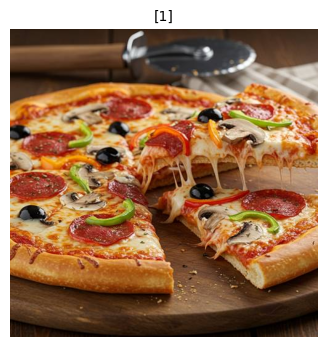

In [15]:
query = '''
作成して。
'''
_ = await client.stream(query)

In [16]:
query = '''
pizzaaaa で保存
'''
_ = await client.stream(query)

[image_creator_agent]

画像を保存します。ファイル名が指定されました。


[image_creator_agent]

画像は pizzaaaa.png という名前で保存されました。

情報を更新して別の画像を作成しますか？




In [17]:
!gsutil ls gs://{BUCKET_NAME}/alice/

gs://zenn-test-457807-adk-design/alice/kapi_mug.png
gs://zenn-test-457807-adk-design/alice/personal_color.png
gs://zenn-test-457807-adk-design/alice/pizzaaaa.png


In [18]:
!gsutil rm gs://{BUCKET_NAME}/alice/*

Removing gs://zenn-test-457807-adk-design/alice/kapi_mug.png...
Removing gs://zenn-test-457807-adk-design/alice/personal_color.png...           
Removing gs://zenn-test-457807-adk-design/alice/pizzaaaa.png...                 
/ [3 objects]                                                                   
Operation completed over 3 objects.                                              


In [19]:
!gsutil ls gs://{BUCKET_NAME}/alice/

CommandException: One or more URLs matched no objects.


In [20]:
async def list_files_tool(tool_context: ToolContext) -> dict:
    """Tool to list available image files for the user."""

    user_id = tool_context._invocation_context.user_id

    try:
        storage_client = storage.Client()
        bucket = storage_client.bucket(BUCKET_NAME)
        blobs = bucket.list_blobs()
        files = []
        for blob in blobs:
            if not blob.name.startswith(f'{user_id}/'):
                continue
            if blob.name.endswith('/'):
                continue
            filename = blob.name.lstrip(f'{user_id}/')
            files.append(filename)
        return {'files': files}

    except Exception as e:
        return {'error': e}

In [21]:
async def analyze_image_tool(instruction: str, filename: str, tool_context: ToolContext):
    """
    Tool to analyze an image using LLM.

    Args:
        instruction: Instruction to LLM on how to analyze an image
        filename: Filename of an image

    Returns:
        dict: A dictionary containing the plan with the following keys:
            filename: Filename of an image
            result: Result of the analysis
    """
    user_id = tool_context._invocation_context.user_id
    filename = f'{user_id}/{filename}'
    try:
        storage_client = storage.Client()
        bucket = storage_client.bucket(BUCKET_NAME)
        blob = bucket.blob(filename)
        blob.reload()
        mime_type = blob.content_type
        image = Part.from_uri(
            file_uri=f'gs://{BUCKET_NAME}/{filename}',
            mime_type=mime_type
        )
        parts = []
        parts.append(Part.from_text(text='[instruction]\n{instruction}'))
        parts.append(Part.from_text(text='[image]'))
        parts.append(image)
        contents = contents=[UserContent(parts=parts)]
        system_instruction = '''
You are a professional image analyst.
Analyze the [image] based on the [instruction].
'''
        response_schema = {
            "type": "object",
            "properties": {
                "filename": {"type": "string"},
                "result": {"type": "string"},
            },
            "required": ["filename", "result"],
        }
        result = generate_response(
            system_instruction, contents,
            response_schema, model='gemini-2.0-flash-001'
        )
        return json.loads(result)

    except Exception as e:
        return {
            'filename': filename,
            'result': f'An unexpected error occurred: {e}'
        }

In [22]:
image_analyst_agent = LlmAgent(
    name='image_analyst_agent',
    model='gemini-2.0-flash',
    instruction='''
You are an agent that analyze image files.
Output in Japanese.

[conditions]
* Avoid mentioning tool names in your reply.
* Show underscore in filenames as "_" instead of "\_".
    - Good example: "my_file.png"
    - Bad example: "my\_file.png"

[tasks]

** List image files
    * You can get a list of image files with list_files_tool().
      Make sure to use the tool. Don't fake the result.

** Display image
    * You can insert an image in your message by inserting a line "<image>_filename_</image>".
      Replace _filename_ with the filename of the image file. 
      Then the user will see the real image in that part.

** Analyze image
    * If you need to analyze an image, use analyze_image_tool().
      Make sure to use the tool. Don't fake the result.

** Answer questions
    * You give an answer to questions from the user regarding images.
        - Analyze the image with the tool "analyze_image" if necessary.
        - Based on the previous conversation, infer the filename of the image
          that the user is asking about.
''',
    description='''
An agent that manage and handling the user's requests regarding image files.
This agent can access saved images, and analyze them.
''',
    tools = [
        list_files_tool,
        analyze_image_tool,
    ],
)

In [39]:
image_design_assistant = LlmAgent(
    name='image_design_assistant',
    model='gemini-2.0-flash',
    global_instruction='''
* A nickname of the root agent (image_design_assistant) is 'コンシェルジュ・イマージュ'.
* A nickname of image_creator_agent is 'ジェネシス・ヴィジョン'.
* A nickname of image_analyst_agent as 'アナリティクス・アイ'.
* Each agent should say their name at the first conversation
  or when they were transferred from another agent.
* You should transfer the agent without asking the user.
''',
    instruction='''
You are an agent that help users create and analyze images.
Output in Japanese.
''',
    description='''
An agent that helps users create and analyze images.
''',
    sub_agents = [
        copy.deepcopy(image_creator_agent),
        copy.deepcopy(image_analyst_agent),
    ]
)

In [40]:
client = LocalApp(image_design_assistant, user_id='alice')
DEBUG = False

query = '''
何ができますか？
'''
_ = await client.stream(query)

[image_design_assistant]

コンシェルジュ・イマージュです。私は、画像作成や分析のお手伝いをすることができます。例えば、画像の生成を依頼したり、保存された画像を分析したりできます。




In [41]:
query = '''
画像を作成してください。
ショップで販売する新しいマグカップのデザインを考えていて、
パステルカラーで洗練された、全面がカピバラ柄のサンプルが欲しいです。
'''
_ = await client.stream(query)

[image_design_assistant]

ジェネシス・ヴィジョンに依頼した方が良さそうですね。



[image_creator_agent]

ジェネシス・ヴィジョンです。

以下の内容で画像を作成してよろしいでしょうか？

*   説明: パステルカラーで洗練された、全面がカピバラ柄のマグカップ
*   目的: ショップで販売する新しいマグカップのデザインのサンプル

内容を更新しますか？




[image_creator_agent]

画像を生成します。少々お待ちください。


[image_creator_agent]

画像が生成できました。

## Displayed image [1] ##

画像をファイル名をつけて保存しますか？それとも、情報を更新して別の画像を作成しますか？
ファイル名を指定する必要があることにご注意ください。




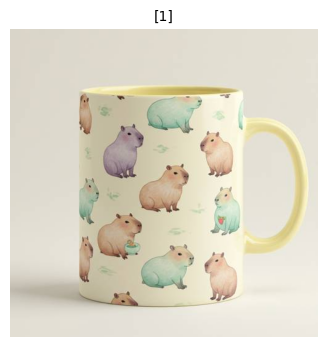

In [42]:
query = '''
作成して。
'''
_ = await client.stream(query)

In [43]:
query = '''
kapi_mug.png で保存して。
'''
_ = await client.stream(query)

[image_creator_agent]

画像を kapi_mug.png というファイル名で保存しました。

情報を更新して別の画像を作成しますか？




In [44]:
!gsutil ls gs://{BUCKET_NAME}/alice/

gs://zenn-test-457807-adk-design/alice/kapi_mug.png
gs://zenn-test-457807-adk-design/alice/kapi_mug2.png


In [45]:
query = '''
いいえ。この画像からSNSで拡散するキャッチコピーを考えて。
'''
_ = await client.stream(query)

[image_creator_agent]

コンシェルジュ・イマージュに転送します。




[image_design_assistant]

アナリティクス・アイに依頼した方が良さそうですね。



[image_analyst_agent]

アナリティクス・アイです。

SNSで拡散するキャッチコピーを考えるために、画像を分析する必要があります。





In [46]:
query = '''
この柄を特に好むターゲット層を考えて、そこにアピールするシンプルで効果的なメッセージをお願い。
'''
_ = await client.stream(query)

[image_analyst_agent]

ターゲット層を考慮したキャッチコピーを考案するために、まず画像 kapi_mug.png の分析を行います。どのようなターゲット層にアピールするか、指示をしてください。




In [47]:
query = '''
この柄を特に好むターゲット層も考えて、そこにアピールするシンプルで効果的なメッセージをお願い。
'''
_ = await client.stream(query)

[image_analyst_agent]

画像 kapi_mug.png を分析して、ターゲット層を特定し、アピールするメッセージを考案します。




In [29]:
PROJECT_ID=$(gcloud config list --format 'value(core.project)')
PROJECT_NUMBER=$(gcloud projects describe $PROJECT_ID --format='value(projectNumber)')
gcloud projects add-iam-policy-binding $PROJECT_ID \
    --member="serviceAccount:service-${PROJECT_NUMBER}@gcp-sa-aiplatform-re.iam.gserviceaccount.com" \
    --role='roles/storage.objectUser'

SyntaxError: invalid syntax (3580511931.py, line 1)

In [48]:
from vertexai import agent_engines

remote_agent = agent_engines.create(
    agent_engine=image_design_assistant,
    display_name='image_design_assistant',
    requirements=[
        'google-adk==1.2.1',
        'pillow',
    ]
)

Deploying google.adk.agents.Agent as an application.
Identified the following requirements: {'google-cloud-aiplatform': '1.96.0', 'cloudpickle': '3.1.1', 'pydantic': '2.11.5'}
The following requirements are missing: {'google-cloud-aiplatform', 'cloudpickle', 'pydantic'}
The following requirements are appended: {'pydantic==2.11.5', 'cloudpickle==3.1.1'}
The final list of requirements: ['google-adk==1.2.1', 'pillow', 'pydantic==2.11.5', 'cloudpickle==3.1.1']
Using bucket zenn-test-457807
Wrote to gs://zenn-test-457807/agent_engine/agent_engine.pkl
Writing to gs://zenn-test-457807/agent_engine/requirements.txt
Creating in-memory tarfile of extra_packages
Writing to gs://zenn-test-457807/agent_engine/dependencies.tar.gz
Creating AgentEngine
Create AgentEngine backing LRO: projects/497948777685/locations/us-central1/reasoningEngines/3910646200650432512/operations/1463356346282803200
View progress and logs at https://console.cloud.google.com/logs/query?project=zenn-test-457807
AgentEngine cr

In [49]:
class RemoteApp:
    def __init__(self, remote_agent, user_id='default_user'):
        self._remote_agent = remote_agent
        self._user_id = user_id
        self._session = remote_agent.create_session(user_id=self._user_id)

    def _process_parts(self, author, parts, num_images):
        def replace(match):
            nonlocal num_images
            num_images += 1
            return f'## Displayed image [{num_images}] ##'

        response = ''
        while parts:
            part = parts.pop(0)
            if 'text' not in part:
                continue

            # Display images in artifacts
            pattern = '<artifact>(.+?)</artifact>'
            inline_images = re.findall(pattern, part['text'])
            for c, filename in enumerate(inline_images):
                if filename.startswith('_none_'):
                    continue
                base64_data = parts.pop(0)['text'].split(',')[1]
                image_bytes = base64.b64decode(base64_data)
                display_image_bytes(image_bytes, f'[{num_images+c+1}]')
            part['text'] = re.sub(pattern, replace, part['text'])

            # Display images in the storage bucket
            pattern = '<image>(.+?)</image>'
            bucket_images = re.findall(pattern, part['text'])
            for c, filename in enumerate(bucket_images):
                title = f'[{num_images+c+1}] {filename}'
                display_image(f'{self._user_id}/{filename}', title)
            part['text'] = re.sub(pattern, replace, part['text'])

            response += f'[{author}]\n\n{part["text"]}\n'
        return response, num_images


    def _stream(self, query):
        events = self._remote_agent.stream_query(
            user_id=self._user_id,
            session_id=self._session['id'],
            message=query,
        )
        result = []
        num_images = 0
        for event in events:
            if DEBUG:
                print(f'----\n{event}\n----')
            if not ('content' in event and 'parts' in event['content']):
                continue
            parts = copy.deepcopy(event['content']['parts'])
            response, num_images = self._process_parts(
                event['author'], parts, num_images
            )
            if response:
                print(response)
                result.append(response)
        return result


    def stream(self, query):
        # Retry 4 times in case of resource exhaustion
        for c in range(4):
            if c > 0:
                time.sleep(2**(c-1))
            result = self._stream(query)
            if result:
                return result
            if DEBUG:
                print('----\nRetrying...\n----')
        return None # Permanent error

In [50]:
remote_client = RemoteApp(remote_agent, user_id='bob')
DEBUG = False

query = '''
何ができますか？
'''
_ = remote_client.stream(query)

[image_design_assistant]

コンシェルジュ・イマージュです。私は画像作成と分析のお手伝いをすることができます。画像の作成をご希望の場合はジェネシス・ヴィジョンに、画像の分析をご希望の場合はアナリティクス・アイに依頼することも可能です。




In [51]:
ARTIFACT_BUCKET_NAME = f'{PROJECT_ID}-adk-artifact'
!gsutil mb -b on -l {LOCATION} gs://{ARTIFACT_BUCKET_NAME}

Creating gs://zenn-test-457807-adk-artifact/...
ServiceException: 409 A Cloud Storage bucket named 'zenn-test-457807-adk-artifact' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [52]:
from vertexai.preview.reasoning_engines import AdkApp
from google.adk.artifacts import GcsArtifactService

def set_gcs_artifact_service(agent, artifact_bucket_name):    

    def artifact_service_builder():
        return GcsArtifactService(bucket_name=artifact_bucket_name)

    return AdkApp(
       agent=agent,
       artifact_service_builder=artifact_service_builder,
    )

In [ ]:
from vertexai import agent_engines

agent_with_gcs_artifact_service = set_gcs_artifact_service(
    image_design_assistant,
    ARTIFACT_BUCKET_NAME,
)

remote_agent = agent_engines.create(
    agent_engine=agent_with_gcs_artifact_service,
    display_name='image_design_assistant',
    requirements=[
        'google-adk==1.2.1',
        'pillow',
    ]
)

Identified the following requirements: {'google-cloud-aiplatform': '1.96.0', 'cloudpickle': '3.1.1', 'pydantic': '2.11.5'}
The following requirements are missing: {'google-cloud-aiplatform', 'cloudpickle', 'pydantic'}
The following requirements are appended: {'pydantic==2.11.5', 'cloudpickle==3.1.1'}
The final list of requirements: ['google-adk==1.2.1', 'pillow', 'pydantic==2.11.5', 'cloudpickle==3.1.1']
Using bucket zenn-test-457807
Wrote to gs://zenn-test-457807/agent_engine/agent_engine.pkl
Writing to gs://zenn-test-457807/agent_engine/requirements.txt
Creating in-memory tarfile of extra_packages
Writing to gs://zenn-test-457807/agent_engine/dependencies.tar.gz
Creating AgentEngine
Create AgentEngine backing LRO: projects/497948777685/locations/us-central1/reasoningEngines/3099998267723743232/operations/1425920174380285952
View progress and logs at https://console.cloud.google.com/logs/query?project=zenn-test-457807
